In [0]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

# Ejercicio Pesos y Alturas

Vamos a trabajar con un dataset que registra el peso y la altura de 10000 personas, y buscaremos clasificar en hombres y mujeres.

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/rn-2019-itba/Clase-3--LDA-QDA-RL/master/dataset/alturas-pesos-mils-train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/rn-2019-itba/Clase-3--LDA-QDA-RL/master/dataset/alturas-pesos-mils-test.csv')
print('Casos de train:' ,len(data.index))
print('Casos de test:', len(test.index))
data.head()


Casos de train: 8000
Casos de test: 2000


,Unnamed: 0,Genero,Peso,Altura
0,7620,Mujer,61.235,162.402
1,1837,Hombre,97.432,181.908
2,3311,Hombre,73.324,172.459
3,9478,Mujer,55.193,157.748
4,7805,Mujer,56.886,151.798


In [5]:
data_hombres = data.loc[data['Genero']=='Hombre'][['Peso','Altura']].values
data_mujeres = data.loc[data['Genero']=='Mujer'][['Peso','Altura']].values
data_hombres_test = test.loc[data['Genero']=='Hombre'][['Peso','Altura']].values
data_mujeres_test = test.loc[data['Genero']=='Mujer'][['Peso','Altura']].values
print(data_hombres)

[[ 97.432 181.908]
 [ 73.324 172.459]
 [ 77.618 172.705]
 ...
 [ 83.84  177.866]
 [ 75.461 170.91 ]
 [ 80.323 171.575]]


Grafiquemos los datos

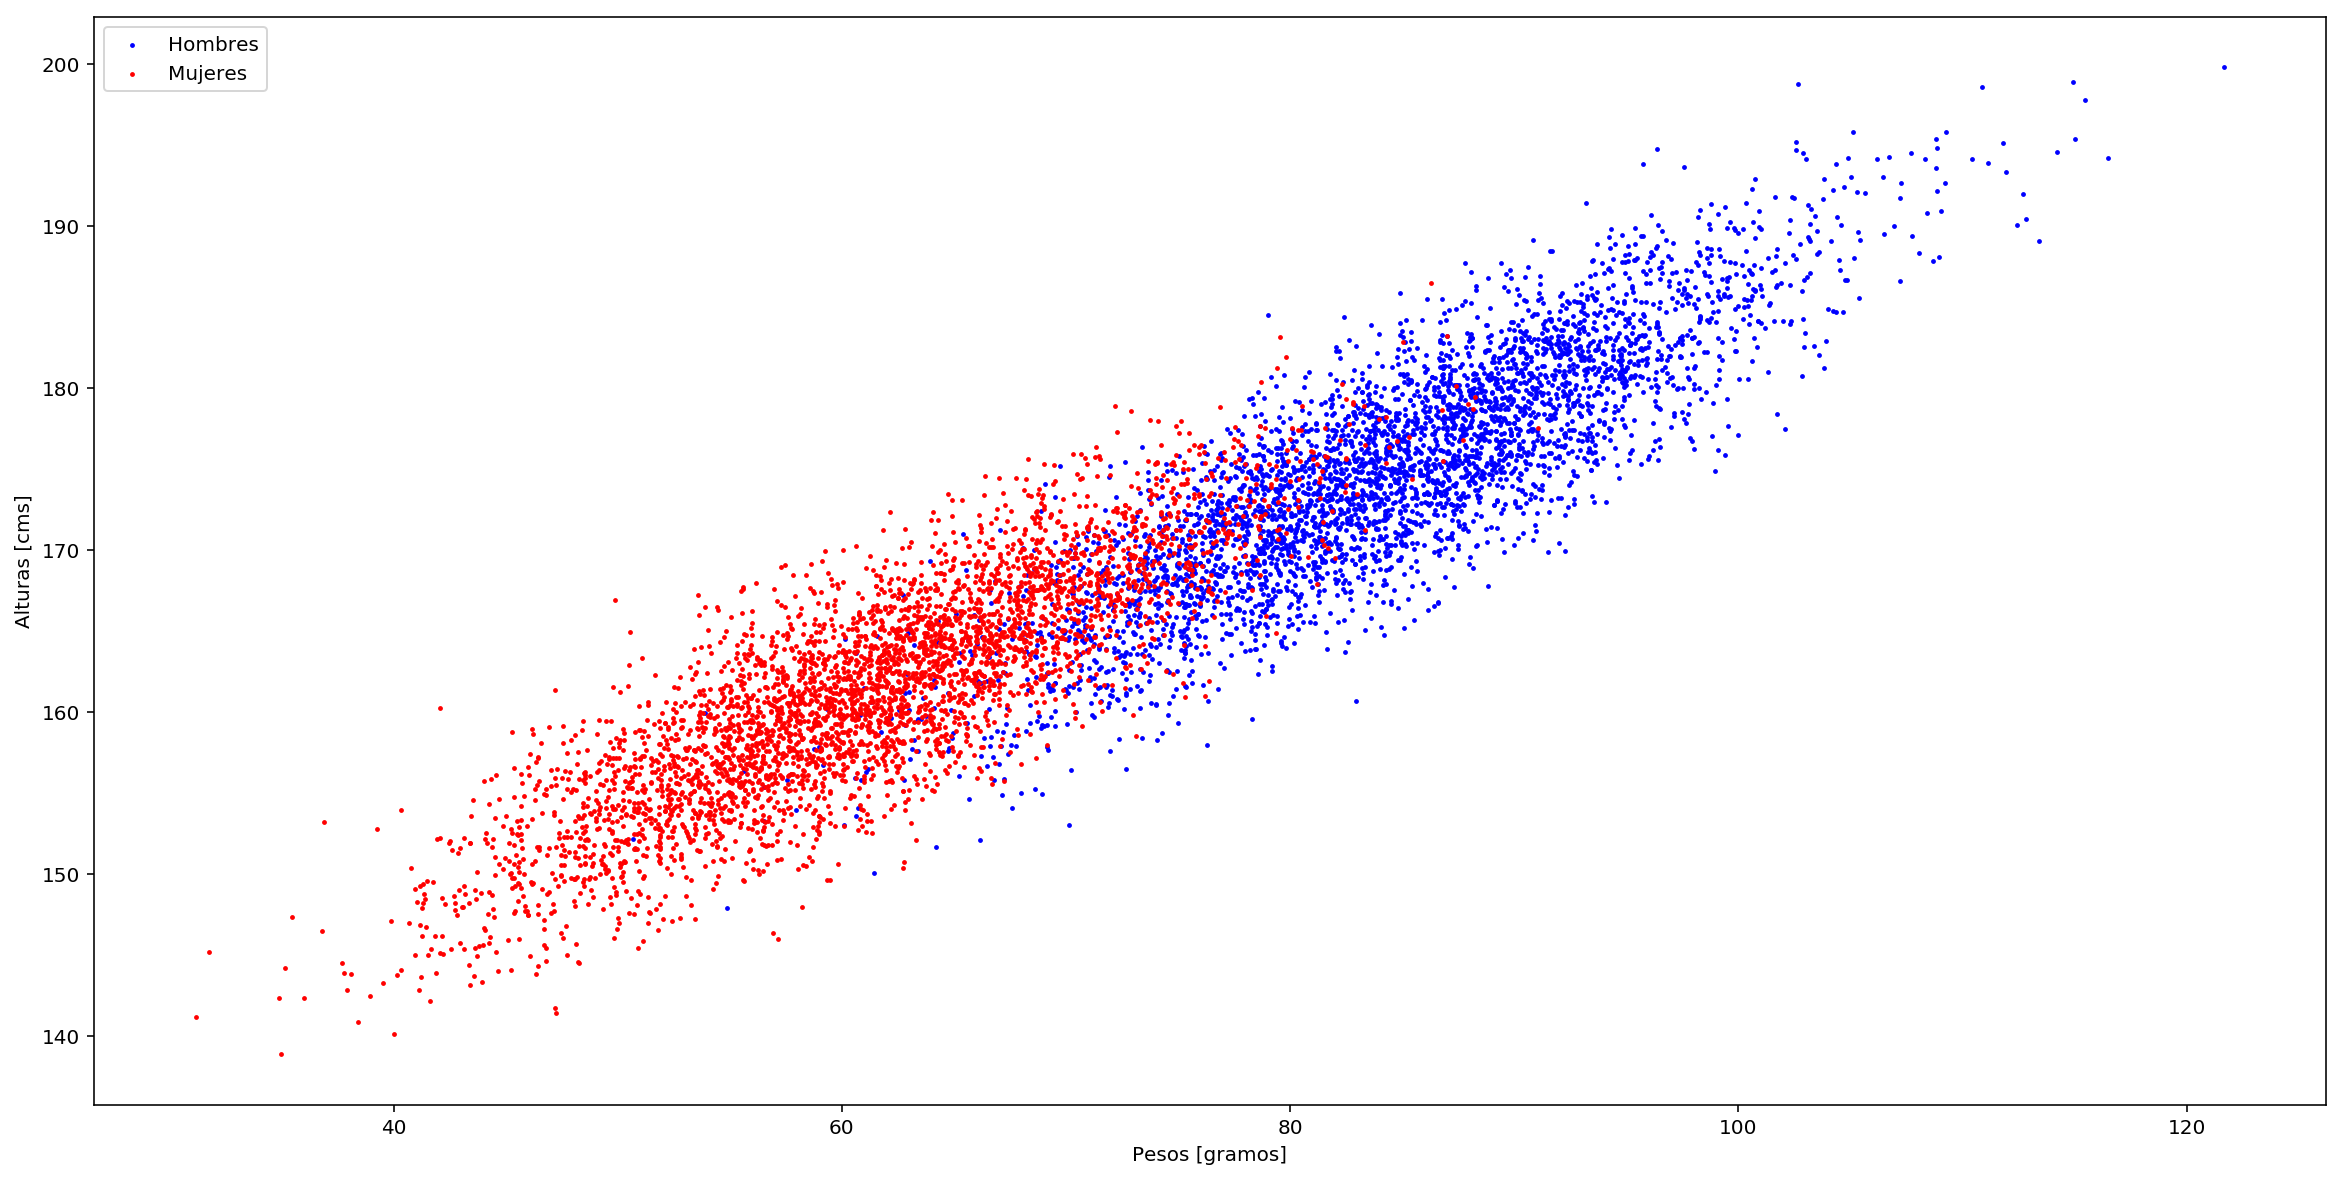

In [6]:
f = plt.figure(figsize=(20,10))
plt.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, label='Hombres')
plt.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, label='Mujeres')
plt.xlabel('Pesos [gramos]')
plt.ylabel('Alturas [cms]')
plt.legend()
plt.show()

##Modelo Naive Bayes Gaussiano


$$\text{Bayes:    }  P(y=k | X) = \frac{P(X | y=k) P(y=k)}{P(X)} $$ 

Desde un punto de vista de modelo generativo, podemos pensar que la probabilidad de que sea hombre y de que sea mujer dado que observamos una cierta combinación de pesos y alturas *a,p* es: 

$$P(Y=Mujer | A,P=a,p) = \frac{P( A,P=a,p| Y=Mujer) P(Y=Mujer)}{P(A,P=a,p)}$$
$$P(Y=Hombre | A,P=a,p) = \frac{P( A,P=a,p| Y=Hombre) P(Y=Hombre)}{P(A,P=a,p)}$$

¿Pero cómo podemos calcular $P(A,P=a,p| Y=Mujer)$ y $P( A,P=a,p| Y=Hombre)$? Dependerá de cómo modelemos la distribución de peso y altura para cada una de las dos clases.

Una opción es modelar la distribución de las variables como una **distribución Gaussiana multivariable**. A diferencia de una Gaussiana univariable, donde los parámetros son únicamente la media y la varianza de esa variable, en este caso tendremos que parametrizar también de alguna forma la relación que existe entre las variables. Esto está representado en la matriz de covarianza $\Sigma$, cuyo elemento en la posición i,j es la covarianza entre la i-ésima y la j-ésima variable.  La covarianza expresa la relación lineal entre un par de variables.

En nuestro caso tendremos dos matrices de covarianza, ya que cada uno de nuestros modelos generadores (mujer y hombre) es una distribución Gaussiana multivariable distinta.

$$ \Sigma_{Mujer} =   \begin{matrix} \sigma_{\frac{p,p}{Y=mujer}} & \sigma_{\frac{p,a}{Y=mujer}} \\ \sigma_{\frac{a,p}{Y=mujer}} & \sigma_{\frac{a,a}{Y=mujer}}\end{matrix} $$
$$ \Sigma_{Hombre} =   \begin{matrix} \sigma_{\frac{p,p}{Y=Hombre}} & \sigma_{\frac{p,a}{Y=Hombre}} \\ \sigma_{\frac{a,p}{Y=Hombre}} & \sigma_{\frac{a,a}{Y=Hombre}}\end{matrix} $$


Notemos que en la diagonal tenemos la covarianza de cada variable consigo misma, es decir, es la varianza de esta variable. 

Calculemos $\Sigma_{Y=Mujer}$ y $\Sigma_{Y=Hombre}$:

In [9]:
covMat_mujer = np.cov(data_mujeres,rowvar=False)
print('Matriz de covarianza de Mujeres: ')
print(covMat_mujer)
covMat_hombre = np.cov(data_hombres,rowvar=False)
print('Matriz de covarianza de Hombres: ')
print(covMat_hombre)

Matriz de covarianza de Mujeres: 
[[75.19882927 50.77709625]
 [50.77709625 47.57064786]]
Matriz de covarianza de Hombres: 
[[80.69463867 56.28300274]
 [56.28300274 53.02237224]]


Para parametrizar por completo una distribución gaussiana multivariable, necesitamos también la media de cada variable, según cada modelo generativo. Es decir el peso y la altura promedio de cada género.

In [10]:
media_mujer = np.mean(data_mujeres,axis=0)
media_hombre = np.mean(data_hombres,axis=0)
print('Medias mujeres (kgr,cm): ')
print(media_mujer) 
print('Medias hombres (kgr,cm): ') 
print(media_hombre)

Medias mujeres (kgr,cm): 
[ 61.13789495 161.30471261]
Medias hombres (kgr,cm): 
[ 84.45539805 174.91533033]


Podemos calcular $P(A,P=a,p | Y=Mujer)$ para el modelo de $Y=Mujer$ en función de la matriz de covarianza $\Sigma_{Mut=0}$, la media $\mu_{Mut=0}$, y la cantidad de variables $d$, con la fórmula de la gaussiana multivariable:

$$P(A,P=a,p | Y=Mujer) = \frac{1}{(2\pi)^{d/2} |\Sigma_{mujer}|^{1/2}}\exp\left(-\frac{1}{2} (a,p-\mu_{mujer})^t \Sigma_{mujer}^{-1} (a,p-\mu_{mujer})\right)$$

In [0]:
from scipy.stats import multivariate_normal
def get_gauss_prob(data, mean_1, mean_2, cov_1, cov_2, N_class_1, N_class_2):
    data_np = data
    likelihood_class_1 = multivariate_normal.pdf(data_np, mean_1, cov_1)
    likelihood_class_2 = multivariate_normal.pdf(data_np, mean_2, cov_2)
    prior_1 = N_class_1/(N_class_1 + N_class_2)
    prior_2 = N_class_2/(N_class_1 + N_class_2)
    total = likelihood_class_1 * prior_1 + likelihood_class_2 * prior_2
    p_class_1 = likelihood_class_1 * prior_1/total
    p_class_2 = likelihood_class_2 * prior_2/total
    return p_class_1, p_class_2

In [12]:
p = 60 #60kg
a = 150 #1.5m
prob_mujer,prob_hombre = get_gauss_prob([p,a], media_mujer, media_hombre, covMat_mujer, covMat_hombre,len(data_mujeres),len(data_hombres))
print('Prob de que sea mujer:', prob_mujer)
print('Prob de que sea hombre: ',prob_hombre)

Prob de que sea mujer: 0.8597920958368251
Prob de que sea hombre:  0.1402079041631749


$$\begin{align}\begin{aligned} P(y=Mujer|A,P=a,p)> P(y=Hombre|A,P=a,p) \Leftrightarrow logODDS > 0\end{aligned}\end{align} $$



## LDA

Evaluar cuál modelo tiene mayor probabilidad a posteriori se puede también entender como evaluar el signo del logaritmo del cociente de probabilidades a posteriori, conocido como $logODDS$:
$$logODDS = \log\left(\frac{P(y=Mujer|A,P=a,p)}{P(y=Hombre|A,P=a,p)}\right)$$




Si asumimos que las matrices de covarianza son iguales para ambas clases, se puede demostrar que, aplicando la fórmula de gaussiana multivariable, la expresión de este logaritmo se reduce a:


$$  \begin{align*} logODDS &= X^{T}[\Sigma^{-1}( \mu_{Mut=0} - \mu_{Mut=1})] + log(\frac{P(C_0)}{P(C_1)}) - \frac{1}{2}(\vec{\mu}_0+\vec{\mu}_1)^T\Sigma^{-1}(\vec{\mu}_0-\vec{\mu}_1) \\ &= X^{T} w + C \end{align*}$$

La frontera de decisión es una recta, y la decisión depende del signo de logODDS. Es por eso que este método se conoce como **análisis discriminativo lineal (LDA).** 

### Supone $\Sigma_0=\Sigma_1$

In [13]:
cov_LDA = np.cov(np.vstack([data_hombres - media_hombre, data_mujeres - media_mujer]).T)
cov_LDA

array([[77.93836353, 53.52473405],
       [53.52473405, 50.2915853 ]])

In [0]:
def get_acc_gauss(data, mean_1, mean_2, cov_1, cov_2, N_class_1, N_class_2, name_class_1):
    p_class_1, p_class_2 = get_gauss_prob(data[['Peso', 'Altura']].values, mean_1, mean_2, cov_1, cov_2, N_class_1, N_class_2)
    return ((p_class_1>p_class_2)==(data['Genero']==name_class_1)).sum()/len(p_class_1)

In [15]:
print('EN TRAIN')
acc_gauss =  get_acc_gauss(data, media_hombre, media_mujer, covMat_hombre, covMat_mujer,len(data_hombres),len(data_mujeres),name_class_1='Hombre')
print('Acc sin asumir matrices de covarianza iguales: ', acc_gauss)
acc_LDA =  get_acc_gauss(data, media_hombre, media_mujer, cov_LDA,cov_LDA,len(data_hombres),len(data_mujeres),name_class_1='Hombre')
print('Acc asumiendo matrices de covarianza iguales: ', acc_LDA)

EN TRAIN
Acc sin asumir matrices de covarianza iguales:  0.91675
Acc asumiendo matrices de covarianza iguales:  0.91675


In [16]:
print('EN TEST')
acc_gauss_test =  get_acc_gauss(test, media_hombre, media_mujer, covMat_hombre, covMat_mujer,len(data_hombres), len(data_mujeres),name_class_1='Hombre')
print('Acc sin asumir matrices de covarianza iguales: ', acc_gauss_test)
acc_LDA_test =  get_acc_gauss(test, media_hombre, media_mujer, cov_LDA,cov_LDA,len(data_hombres),len(data_mujeres),name_class_1='Hombre')
print('Acc asumiendo matrices de covarianza iguales: ', acc_LDA_test)

EN TEST
Acc sin asumir matrices de covarianza iguales:  0.9225
Acc asumiendo matrices de covarianza iguales:  0.9225


In [0]:
N = 300
X = np.linspace(data.min()['Peso'], data.max()['Peso'], N)
Y = np.linspace(data.min()['Altura'], data.max()['Altura'], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
Z_H_LDA = multivariate_normal.pdf(pos, media_hombre, cov_LDA)
Z_M_LDA = multivariate_normal.pdf(pos, media_mujer, cov_LDA)
Z_LDA, _ = get_gauss_prob(pos, media_hombre, media_mujer, cov_LDA, cov_LDA,len(data_hombres), len(data_mujeres))

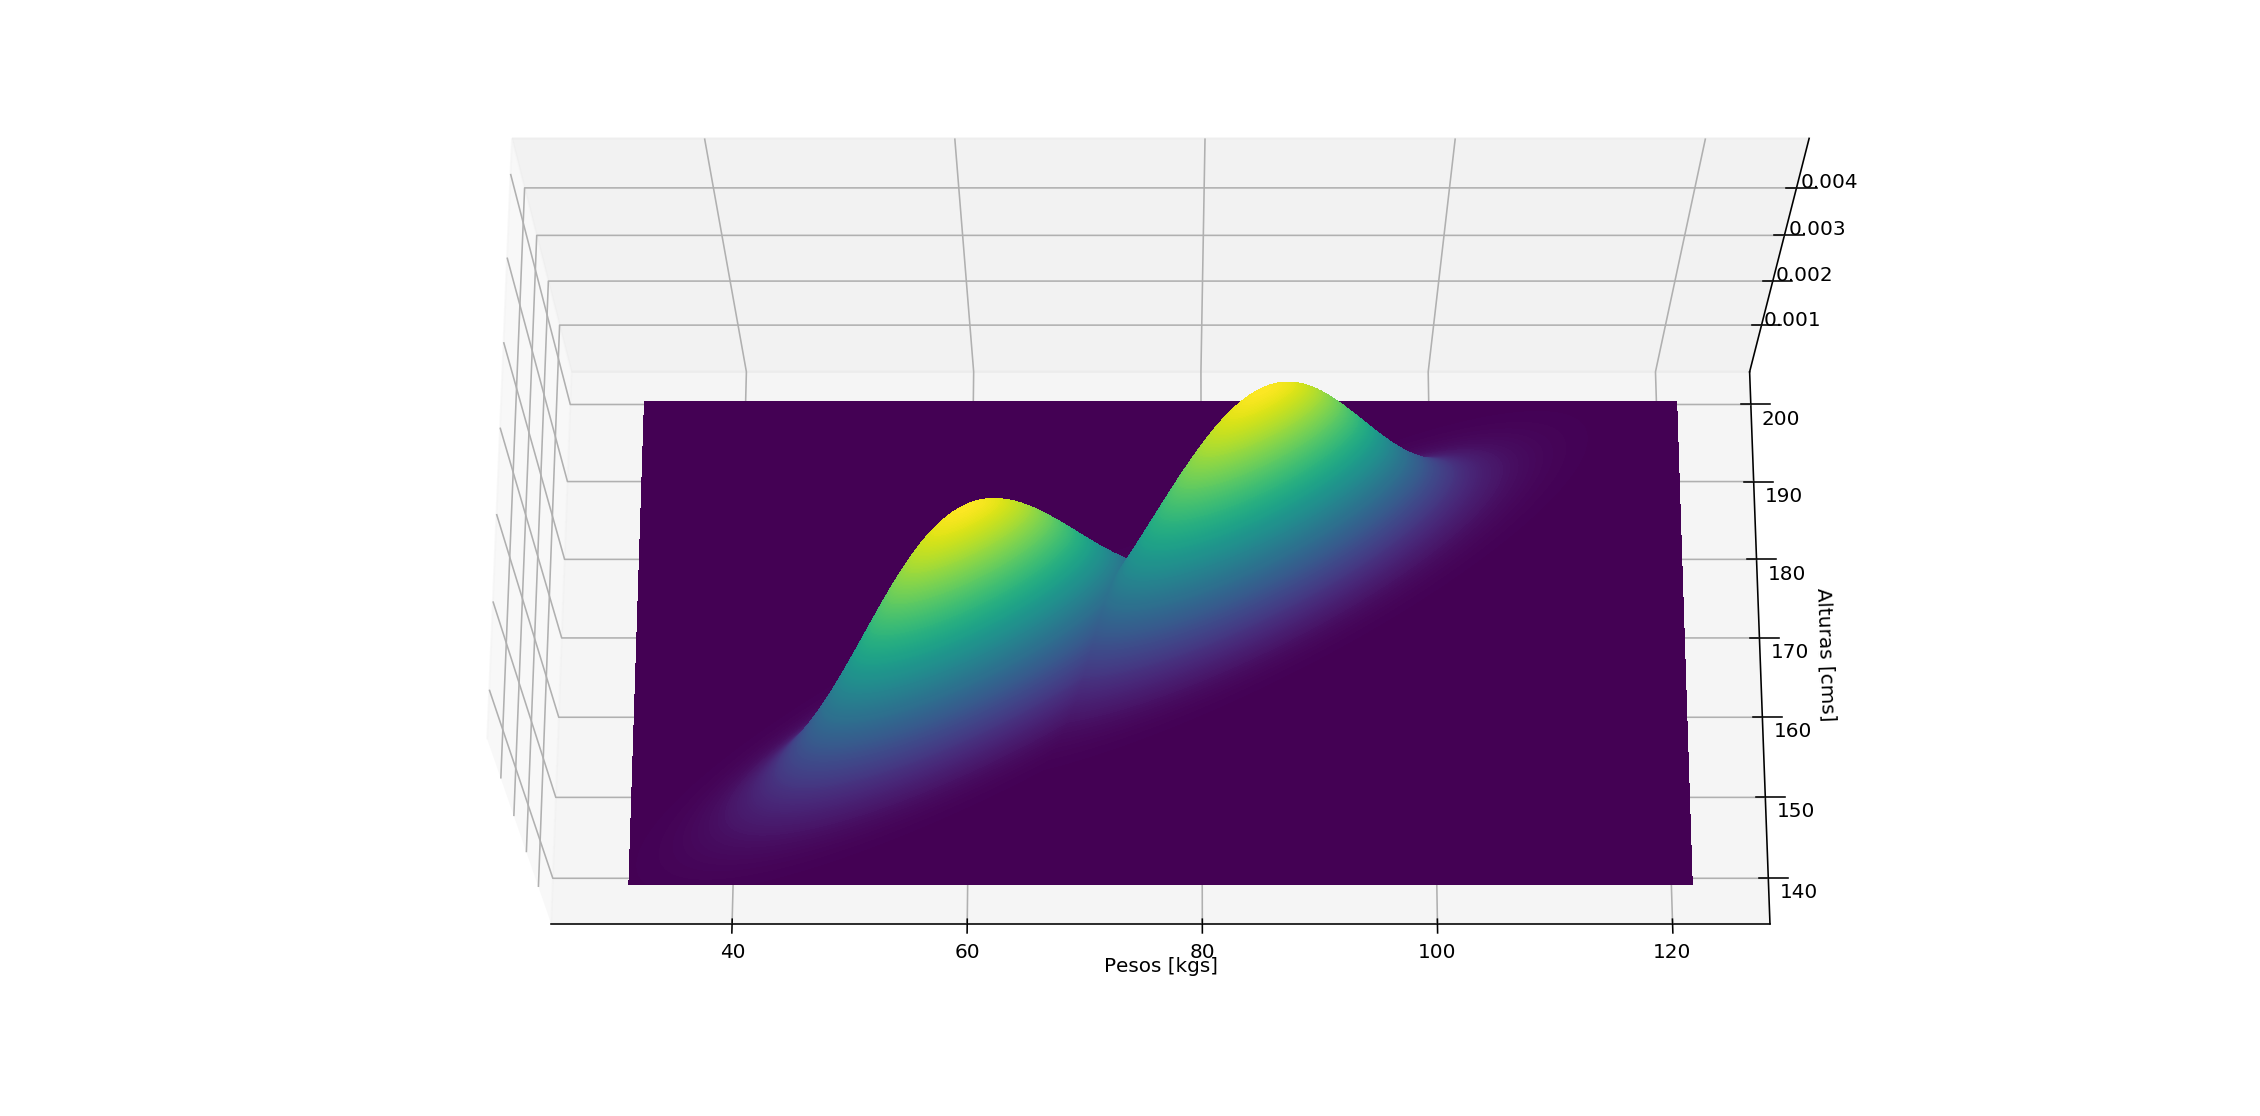

In [18]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
cm = plt.cm.RdBu

ax.contourf(X, Y, Z_H_LDA, 256)
ax.contourf(X, Y, Z_M_LDA, 256)
ax.view_init(70, -90)
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.show()

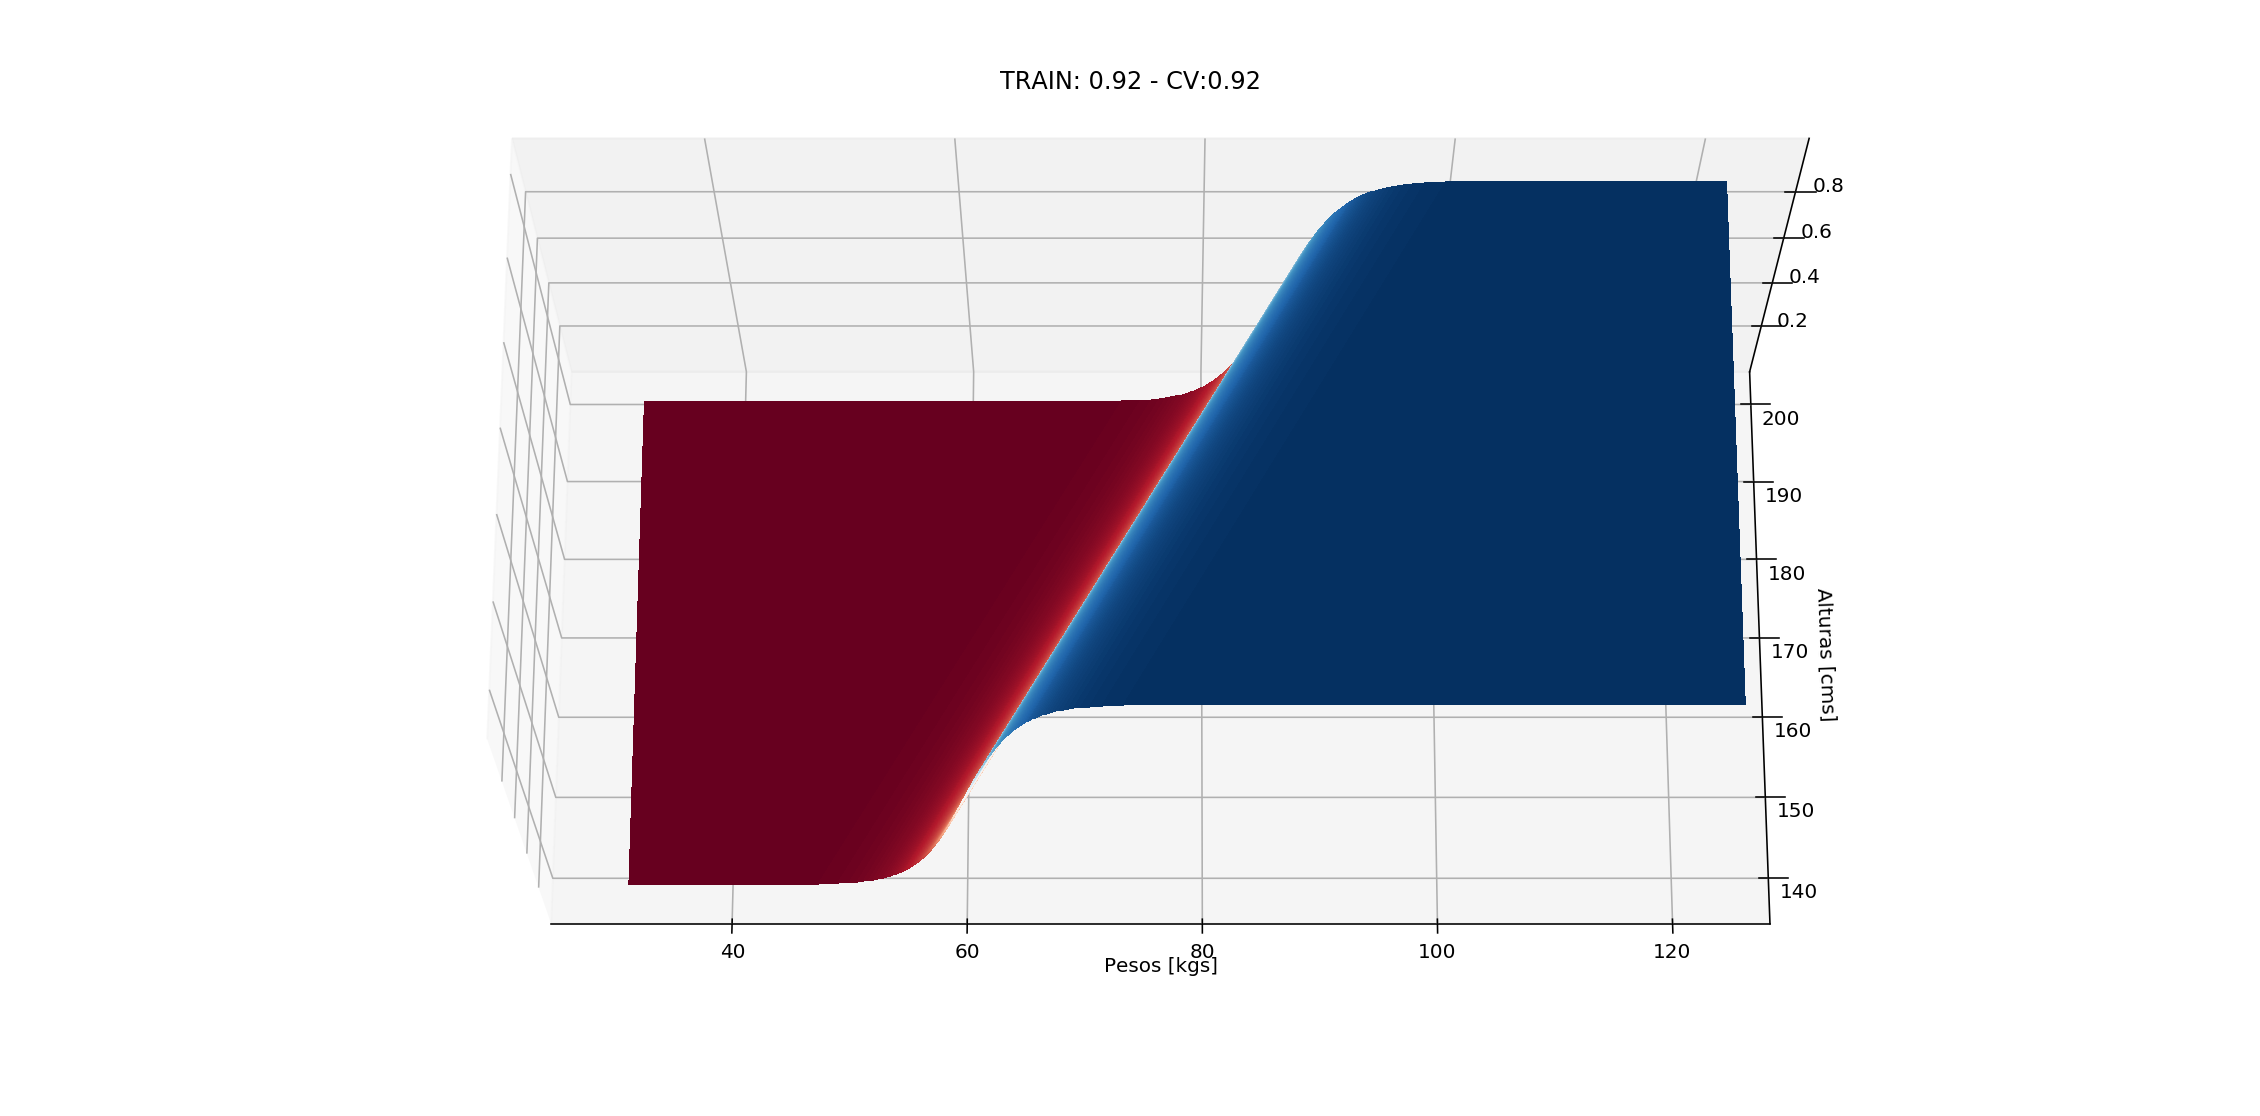

In [19]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
cm = plt.cm.RdBu
ax.contourf(X, Y, Z_LDA, 256, vmin=0., vmax=1., cmap=cm)
ax.set_title('TRAIN: ' + str(np.round(acc_LDA*100)/100) + ' - CV:' + str(np.round(acc_LDA_test*100)/100))
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
ax.view_init(70, -90)
plt.show()

In [20]:
W = np.linalg.inv(cov_LDA).dot(media_mujer - media_hombre)
C = np.log(data_mujeres.shape[0]/data_hombres.shape[0]) - 0.5*(media_mujer + media_hombre).T.dot(np.linalg.inv(cov_LDA)).dot(media_mujer - media_hombre)

logodds_ap=np.array([p,a]).dot(W) + C
print(logodds_ap)

2.172361730047655


¿Dirías que es hombre o mujer?

In [0]:
# Verificación ecuación
z_teorica = np.zeros([N, N])
for row in range(pos.shape[0]):
    for col in range(pos.shape[1]):
        z_teorica[row, col] = pos[row, col].T.dot(W) + C

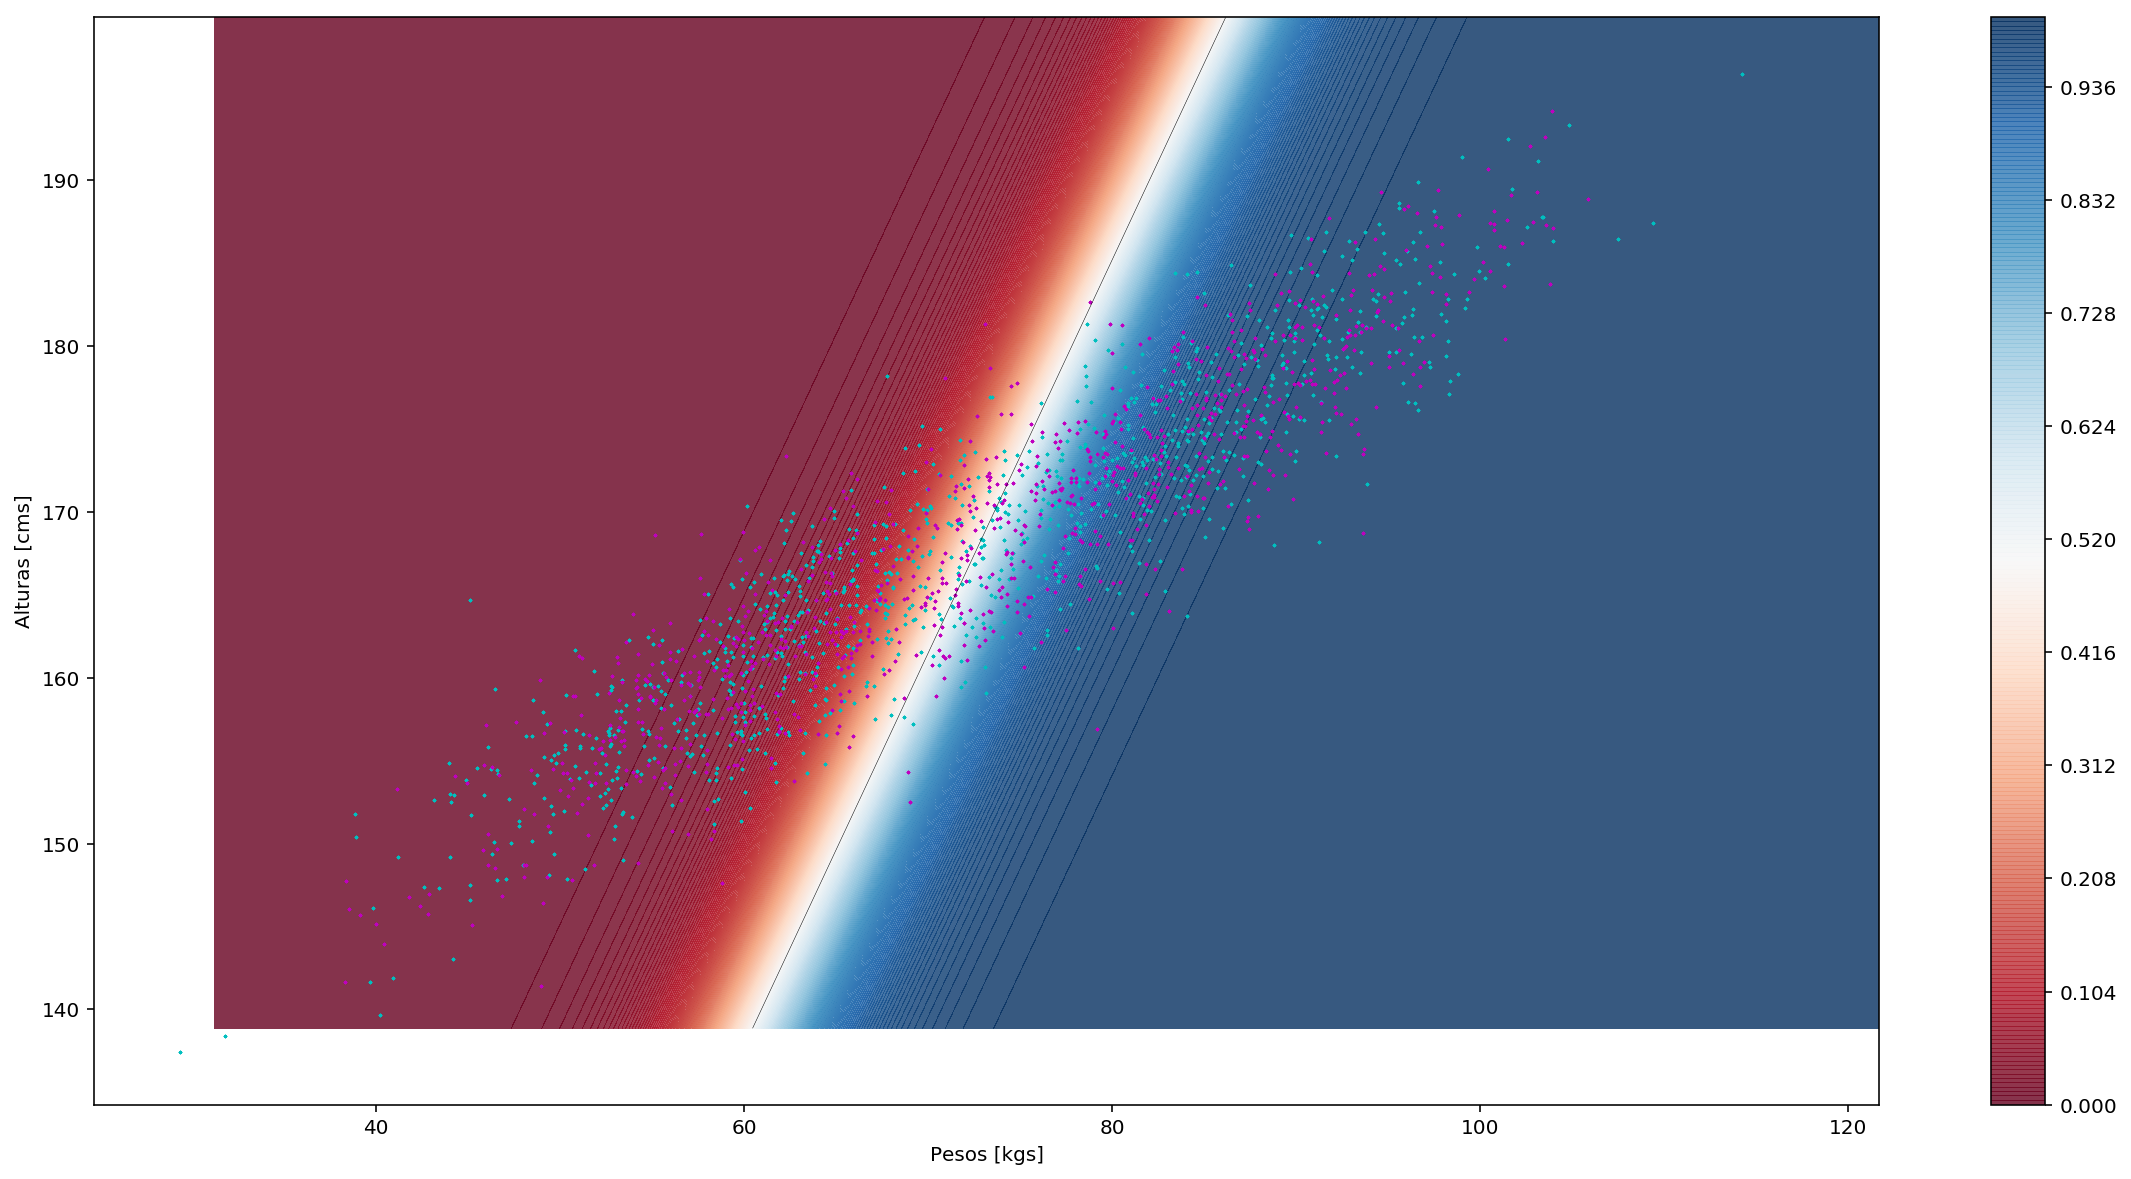

In [22]:
# Verificación
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cf = ax.contourf(X, Y, Z_LDA, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
z_levels = np.logspace(-5,-2,10)/4
#ax.contour(X, Y, Z_H, z_levels)
#ax.contour(X, Y, Z_M, z_levels)

#ax.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=1, label='Hombres')
#ax.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=1, label='Mujeres')
#Agregar test:
ax.scatter(data_hombres_test[:,0], data_hombres_test[:,1], color='c', marker='x', s=1, label='Hombres')
ax.scatter(data_mujeres_test[:,0], data_mujeres_test[:,1], color='m', marker='x', s=1, label='Mujeres')
ax.contour(X, Y, Z_LDA, (0.5,), colors='k', linewidths=0.25)
#ax.contour(X, Y, z_teorica, (0,), colors='k', linewidths=0.25)
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.show()

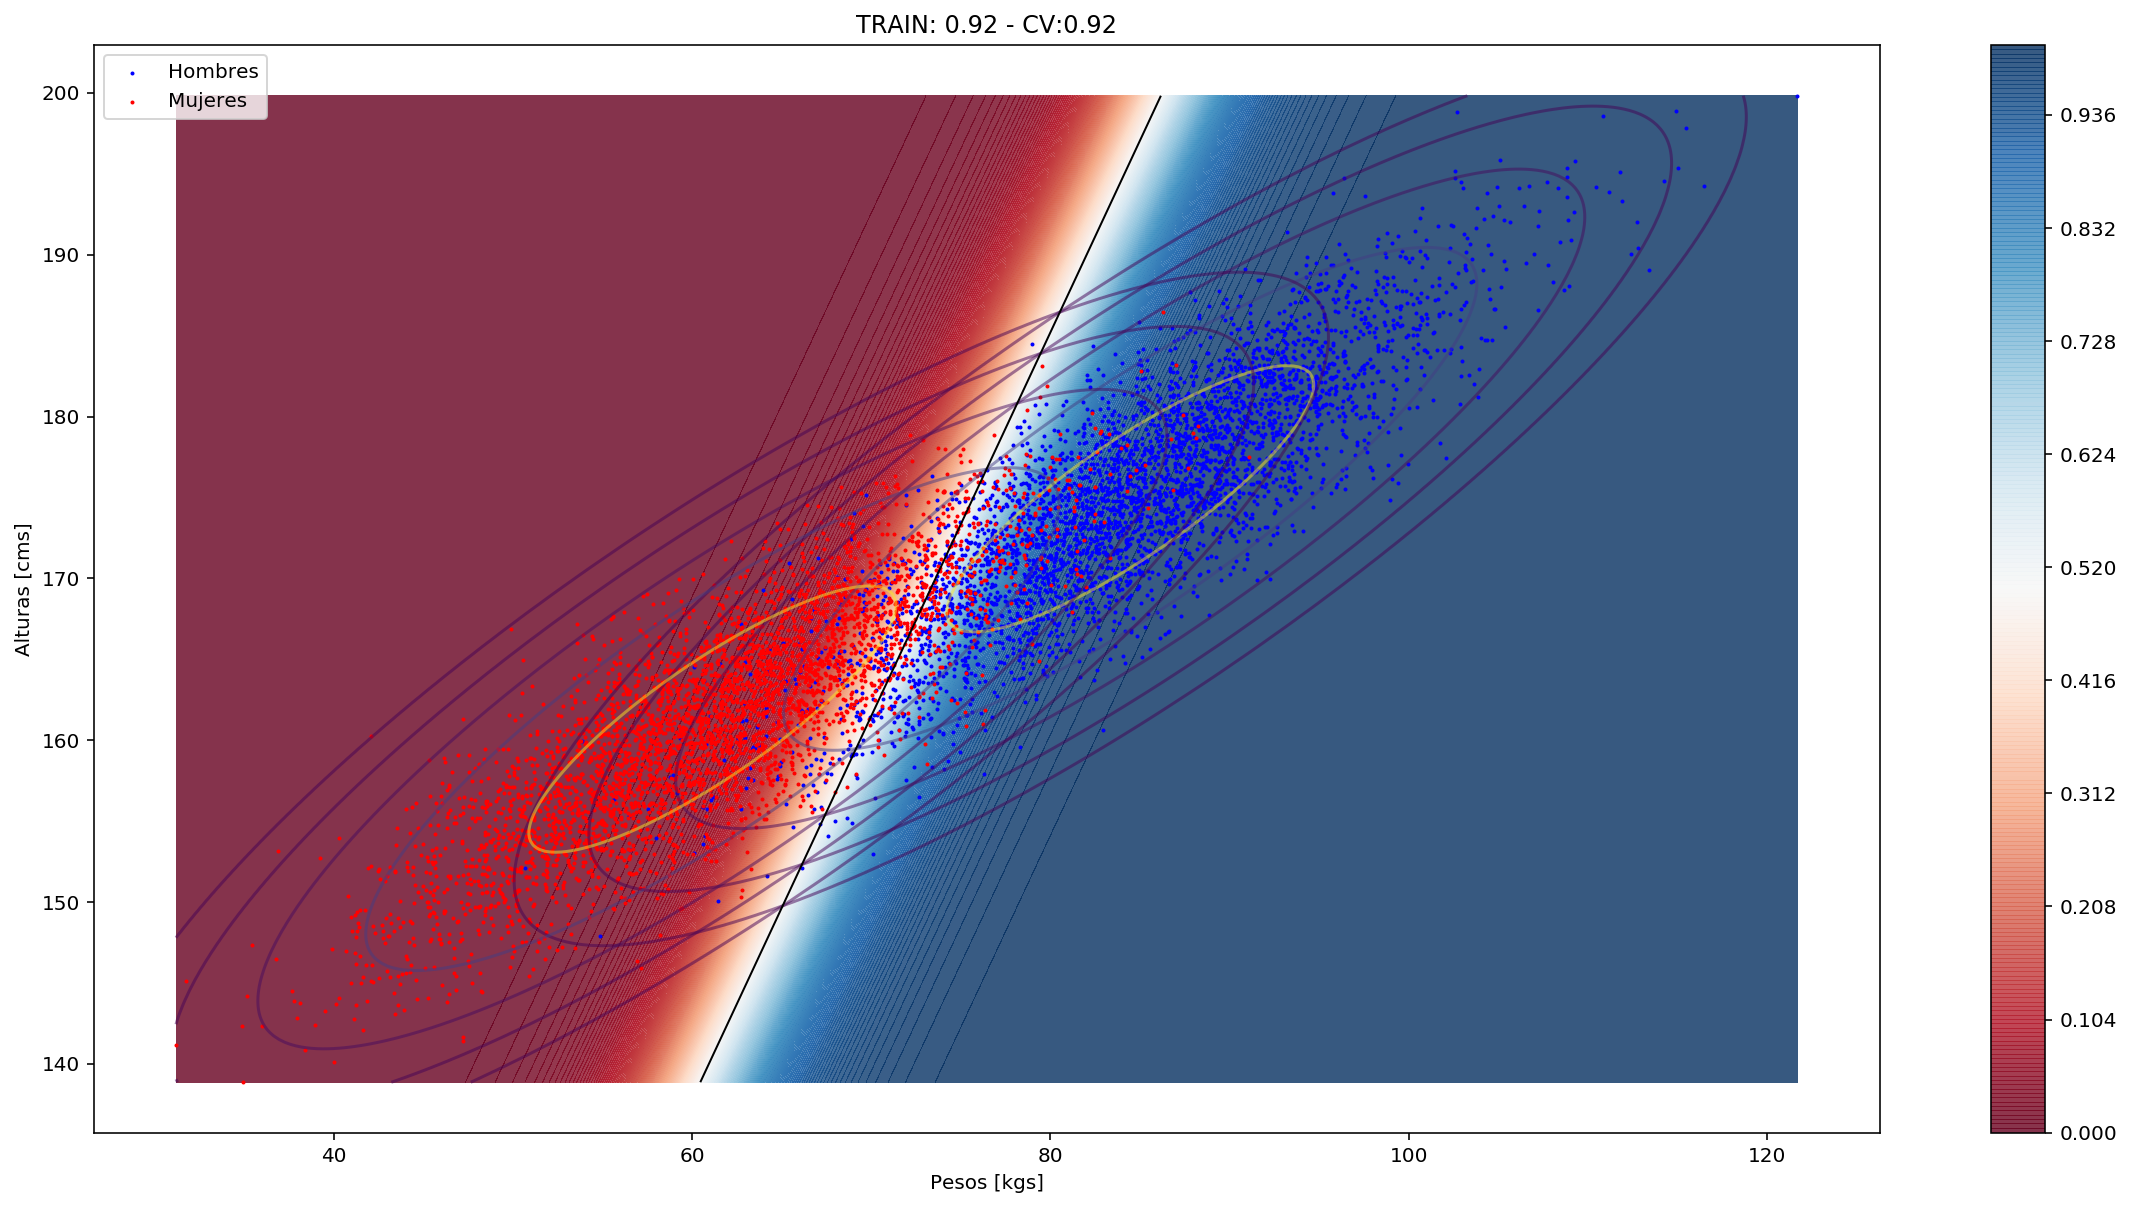

In [23]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cf = ax.contourf(X, Y, Z_LDA, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
z_levels = np.logspace(-5,-2,5)/4
ax.contour(X, Y, Z_H_LDA, z_levels, alpha=0.5)
ax.contour(X, Y, Z_M_LDA, z_levels, alpha=0.5)
ax.contour(X, Y, Z_LDA, (0.5,), colors='k', linewidths=1)
ax.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=1, label='Hombres')
ax.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=1, label='Mujeres')
ax.set_title('TRAIN: ' + str(np.round(acc_LDA*100)/100) + ' - CV:' + str(np.round(acc_LDA_test*100)/100))
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.legend()
plt.show()

## Comparación para diferentes modelos

|Modelo| tipo| Train Acc| CV Acc|Comentarios
|-| -| -| -|-|
|Histogram - step 0.25|Bayes|0.97|0.68
|Histogram - step 0.25|Naive Bayes|0.89|0.88
|Histogram - step 0.5|Bayes|0.94|0.82
|Histogram - step 0.5|Naive Bayes|0.89|0.88
|Histogram - step 1|Bayes|0.92|0.90
|Histogram - step 1|Naive Bayes|0.89|0.88
|Histogram - step 4|Bayes|0.91|0.92| No generaliza por afuera de la zona de los puntos
|Histogram - step 4|Naive Bayes|0.89|0.88
|Histogram - step 8|Bayes|0.90|0.90
|Histogram - step 8|Naive Bayes|0.87|0.86
|Gaussian|Bayes|0.92|0.92|
|Gaussian|Naive Bayes|0.89|0.89|
|Regresion Logística|-|0.92|0.92|

In [0]:
#agregar lo de normalizacion: en RL reduce tiempo de convergencia, en LDA no cambia nada

## Regresión Logística


Tomando exponencial de logODDS:
$$  \begin{align*} logODDS &= X^{T} w + C \\ 
\frac{P(Y=y | X)}{1-P(Y=y|X)} &= e^{X^{T}w + C} \\
 P(Y=y | X) &= (1-P(Y=y | X))e^{X^{T}w + C} \\
P(Y=y | X) &= e^{X^{T}w + C}  - P(Y=y | X) e^{X^{T}w + C} \\
P(Y=y | X) & =  e^{X^{T}w + C}  -  e^{X^{T}w + C} e^{X^{T}w + C} \\
P(Y=y | X) & = \frac{1}{1 +  e^{-X^{T}w - C}} \rightarrow \text{Regresion Logistica} \end{align*} $$



Tomando $z=X^{T}w + C$:

$$\begin{align*} P(Y=y | X) &= \frac{1}{1 +  e^{-z}} \\ 
 P(Y=y | X) &= \frac{1}{1 +  e^{-z}} = \sigma(z)  \rightarrow \text{Función sigmoidea} \end{align*}$$ 

In [0]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))




def get_y_from_LDA(w,c):
    z = np.array([np.array(x).dot(w) + c for x in data[['Peso', 'Altura']].values])
    z.sort()
    return y


La regresión logística se puede interpretar como la función sigmoidea aplicada a la frontera de decisión lineal de LDA. Cuanto mayor sea la distancia entre las medias de las clases $\rightarrow$ mayor es la pendiente en la recta de LDA  $\rightarrow$ mayor es el módulo de $w$  $\rightarrow$ mayor es la pendiente de la sigmoidea

In [0]:
fig = plt.figure(figsize=(20,10))
z=get_z_from_LDA(W,C)
plt.plot(z,sigmoid(z))

print(np.linalg.norm(W))

In [0]:
""""
big_W = 100*W
print(np.linalg.norm(big_W))
y=get_y_from_LDA(big_W,C)
plt.plot(y,sigmoid(y))

bigger_W = 1000*W
print(np.linalg.norm(bigger_W))
y=get_y_from_LDA(bigger_W,C)
plt.plot(y,sigmoid(y))
"""""

Si N es la cantidad de variables (en nuestro caso dos, peso y altura), y asumimos que son independientes, podemos expresar la probabilidad total como el producto:

$$\begin{align*} \frac{P(Y=0 | X)}{1 - P(Y=0 | X)} &= \frac{P(X|Y=0) P(Y=0)}{1-P(X|Y=0) P(Y=0)} \\ 
                                                         &= \frac{\prod_{i}^{N} P(x_i|Y=0) P(Y=0)}{1 - \ \prod_{i}^{N}P(x_i|Y=0) P(Y=0)}  \end{align*}$$

Tomando logaritmo: 
 
$$\begin{align*} logODDS &= \frac{\sum_{i}^{N} P(x_i|Y=0) + P(Y=0)}{\sum_{i}^{N}P(x_i|Y=1) + P(Y=1)}   \end{align*}$$                                                         
                                                   


$$Loss_{\log}(Y=y, X=x) = -\log \operatorname{P}(Y=y|X=x) = -(y \log (P(Y=y|X=x) + (1 - y) \log (1 - P(Y=y|X=x)) \rightarrow \text{entropía cruzada binaria}$$

Si tomo $ P(Y=y | X=x) = \frac{1}{1 +  e^{-x^{T}w + C}} $ para describir la distribución de probabilidad, lo que busco es minimizar una función convexa.  

In [0]:
from sklearn.linear_model import LogisticRegression
log_Reg = LogisticRegression()
log_Reg.fit(data[['Peso', 'Altura']].values, data['Genero'])

In [0]:
acc_train_LR = log_Reg.score(data[['Peso', 'Altura']].values, data['Genero'])
print('Train acc:',acc_train_LR)

acc_CV_LR = log_Reg.score(test[['Peso', 'Altura']].values, test['Genero'])
print('Test acc:',acc_CV_LR)

In [0]:
log_Reg.predict_proba(test[['Peso', 'Altura']].values)

## Normalización

In [0]:
desvio_hombre = np.std(data_hombres)
data_hombres_normalizado = (data_hombres - media_hombre)/desvio_hombre

desvio_mujer = np.std(data_mujeres)
data_mujeres_normalizado = (data_mujeres - media_mujer)/desvio_mujer

data_normalizada = np.concatenate((data_hombres_normalizado,data_mujeres_normalizado),axis=0)
print(len(data_normalizada))

data_targets=['Hombre']*len(data_hombres_normalizado) + ['Mujer']*len(data_mujeres_normalizado)

In [0]:
import time 
start_time=time.time()
data_all = np.concatenate((data_hombres,data_mujeres),axis=0)
log_Reg.fit(data_all, data_targets)
end_time=time.time()
print('Tiempo de ejecución: ', end_time-start_time)

In [0]:
import time 
start_time=time.time()
log_Reg.fit(data_normalizada, data_targets)
end_time=time.time()
print('Tiempo de ejecución: ', end_time-start_time)

¿Notás un cambio con los datos normalizados? Si aplicás normalización con LDA, ¿se observa alguna diferencia? ¿Por qué?